In [12]:
import numpy as np
from numba import njit, float64
import math
import matplotlib.pyplot as plt

In [5]:
@njit(cache=True, fastmath=True)
def compute_hubble(a, H0, Omega_m, Omega_r, Omega_de):    
    a_inv = 1.0 / a
    a_inv2 = a_inv * a_inv
    a_inv3 = a_inv2 * a_inv
    a_inv4 = a_inv3 * a_inv
    
    return H0 * np.sqrt(Omega_r * a_inv4 + Omega_m * a_inv3 + Omega_de)

In [130]:
@njit(cache=True, fastmath=True)
def solve_fractional_simple_fixed_dt(
    alpha=1.0,
    H0=1.0,
    Omega_m=0.315,
    Omega_r=9.2e-5,
    a_start=1e-6,
    a_end=1.0,
    max_iterations=100000
):
    
    Omega_de = 1.0 - Omega_m - Omega_r
    gamma_inv = 1.0 / math.gamma(alpha + 1.0)
    
    # Transition scales
    a_rad_matter = Omega_r / Omega_m  # ~3e-4
    a_matter_de = (Omega_m / Omega_de) ** (1.0/3.0)  # ~0.77
    
    # Store results
    t_list = [0.0]
    a_list = [a_start]
    
    # History for fractional derivative
    f_history = []  # f(a) = H(a) * a
    
    t = 0.0
    a = a_start
    
    # Initial f(a)
    H = compute_hubble(a, H0, Omega_m, Omega_r, Omega_de)
    f_history.append(H * a)
    
    iteration = 0
    
    while a < a_end and iteration < max_iterations:
        iteration += 1
        
        # Determine current era and select time step
        if a < a_rad_matter:
            # Radiation era
            dt = 1e-12  
        elif a < a_matter_de:
            # Matter era
            dt = 1e-6   
        else:
            # Dark energy era
            dt = 1e-2  
        
        # Current number of history points
        n = len(a_list) - 1
        
        # Compute fractional sum
        sum_term = 0.0
        for j in range(n + 1):
            weight = gamma_inv * ((n + 1 - j) ** alpha - (n - j) ** alpha)
            sum_term += weight * f_history[j]
        
        # Update
        dt_alpha = dt ** alpha
        a_new = a_start + dt_alpha * sum_term
        
        t += dt
        a = a_new
        
        # Store new f(a)
        H_new = compute_hubble(a, H0, Omega_m, Omega_r, Omega_de)
        f_history.append(H_new * a)
        
        t_list.append(t)
        a_list.append(a)
    
    # Convert to arrays
    t_array = np.array(t_list)
    a_array = np.array(a_list)

    
    return t_array, a_array

In [127]:
t1,a1 = solve_fractional_simple_fixed_dt()

In [128]:
# Convert to physical time (s)
H0_physical = 2.19e-18  # s⁻¹
seconds_per_year = 365.25 * 24 * 3600
seconds_per_Gyr = seconds_per_year * 1e9

# Time from Big Bang in s
t_s = t1 / H0_physical

y_ticks = [1e1,1e3,1e5,1e7,1e9,1e11,1e13,1e15,1e17]

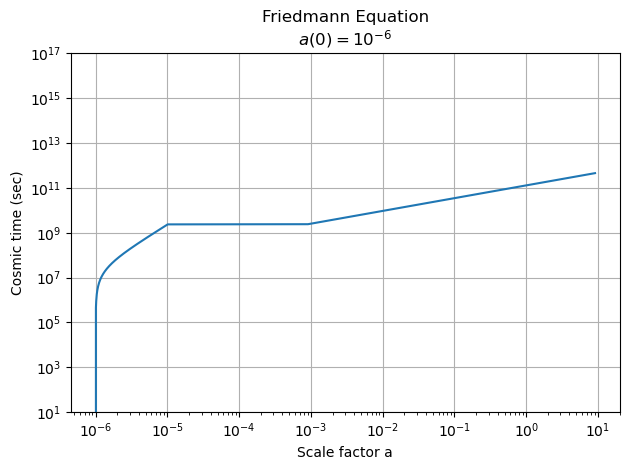

In [129]:
plt.loglog(a1,t_s)
plt.xlabel(r"Scale factor a")
plt.ylabel(r"Cosmic time (sec)")
plt.yticks(y_ticks)
plt.title("Friedmann Equation\n$ a(0)=10^{-6}$")
plt.grid(True)
plt.tight_layout()
plt.show()

In [125]:
a1[10000]

1.399660504737751e-05

In [41]:
t2,a2 = solve_fractional_simple_fixed_dt(max_iterations=1000000)

In [42]:
# Convert to physical time (s)
H0_physical = 2.19e-18  # s⁻¹
seconds_per_year = 365.25 * 24 * 3600
seconds_per_Gyr = seconds_per_year * 1e9

# Time from Big Bang in s
ts2 = t2 / H0_physical

y_ticks = [1e1,1e3,1e5,1e7,1e9,1e11,1e13,1e15,1e17]

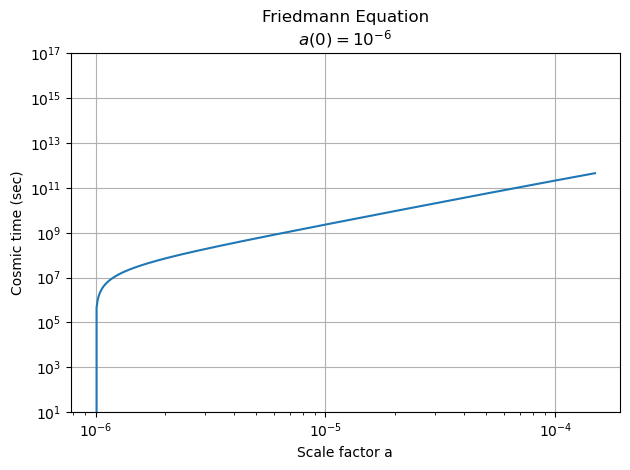

In [43]:
plt.loglog(a2,ts2)
plt.xlabel(r"Scale factor a")
plt.ylabel(r"Cosmic time (sec)")
plt.yticks(y_ticks)
plt.title("Friedmann Equation\n$ a(0)=10^{-6}$")
plt.grid(True)
plt.tight_layout()
plt.show()

In [118]:
a2[900000:]

array([0.00014067, 0.00014067, 0.00014067, ..., 0.00014877, 0.00014877,
       0.00014877])

In [117]:
t2[900000:]

array([9.00000e-07, 9.00001e-07, 9.00002e-07, ..., 9.99998e-07,
       9.99999e-07, 1.00000e-06])